## Test LaSR datasets

In [7]:
import dataset_utils
from importlib import reload
reload(dataset_utils)

<module 'dataset_utils' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/sr_inference_benchmarking/dataset_utils.py'>

In [2]:
dataset_utils.load_datasets('synthetic', 100, 1e-4, equation_indices=list(range(41)), forbid_ops=['log'])


[SyntheticDataset(idx=1, equation="y = ((y1 + -0.2281497263470263) + (sqrt(y3) * (y1 * ((0.6069324861405777 - y3) * y3)))) / cos(cos(y1))", X=(100, 5), y=(100,), var_order={'x0': 'y5', 'x1': 'y3', 'x2': 'y1', 'x3': 'y4', 'x4': 'y2'}),
 SyntheticDataset(idx=2, equation="y = sqrt(exp(y1) * y1) * (cos(y1) + (y1 + y1))", X=(100, 5), y=(100,), var_order={'x0': 'y4', 'x1': 'y3', 'x2': 'y5', 'x3': 'y2', 'x4': 'y1'}),
 SyntheticDataset(idx=3, equation="y = (((exp(y3) + -0.12616306381744816) - (y4 + 0.030015044238449563)) * (-0.10809170430638036 * cos(sqrt(y2) / exp(y4)))) - 1.3429435542734653", X=(100, 5), y=(100,), var_order={'x0': 'y3', 'x1': 'y5', 'x2': 'y1', 'x3': 'y2', 'x4': 'y4'}),
 SyntheticDataset(idx=5, equation="y = (y3 + y2) * ((((y3 + 1.2909882620958377) * y2) + (y1 + y3)) - 0.4061091838418741)", X=(100, 5), y=(100,), var_order={'x0': 'y1', 'x1': 'y4', 'x2': 'y3', 'x3': 'y2', 'x4': 'y5'}),
 SyntheticDataset(idx=7, equation="y = ((0.3850755754421437 * y3) * exp(sqrt(y2) - y1)) / (-0

In [3]:
expr = 'x0 * x1 + x2 - sinh(x1)'
dataset_utils.create_dataset_from_expression(expr, 100, 1e-4)


SyntheticDataset(idx=0, equation="y = x0 * x1 + x2 - sinh(x1)", X=(100, 3), y=(100,), var_order={'x0': 'x1', 'x1': 'x0', 'x2': 'x2'})

Note: Expressions from synthetic dataset without log or sqrt are:
[5, 9, 16, 20, 25, 31, 32, 36, 39]

## PySR integration tests

In [ ]:
os.environ["PYTHON_JULIACALL_JULIA"] = "/cephfs/store/gr-mc2473/lc865/misc/juliaup/juliaup/julia_backup/julia-1.10.7+0.x64.linux.gnu/bin/julia"

In [2]:
from juliacall import Main
Main.Base.julia_cmd()[1]



'/cephfs/store/gr-mc2473/lc865/misc/juliaup/juliaup/julia-1.10.7+0.x64.linux.gnu/bin/julia'

In [5]:
Main.seval("using Pkg; Pkg.status()")

Status `/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/julia_env/Project.toml`
⌅ [6099a3de] PythonCall v0.9.23
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [6]:
import os
os.environ["PYTHON_JULIACALL_JULIA"] = '/cephfs/store/gr-mc2473/lc865/misc/juliaup/juliaup/julia_backup/julia-1.10.7+0.x64.linux.gnu/bin/julia'
from juliacall import Main

from juliacall import Main
Main.Base.julia_cmd()[1]


'/cephfs/store/gr-mc2473/lc865/misc/juliaup/juliaup/julia-1.11.3+0.x64.linux.gnu/bin/julia'

In [ ]:
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/julia_env/Project.toml

In [1]:
from pysr import PySRRegressor, TensorBoardLoggerSpec
from pysr_interface_utils import get_mutation_stats, reset_mutation_stats
import numpy as np
from importlib import reload
import dataset_utils
reload(dataset_utils)
from matplotlib import pyplot as plt

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   GPUArrays [0c68f7d7-f131-5f86-a1c3-88cf8149b2d7]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   ArrayInterfaceCUDAExt [f78586ac-ba87-5ec7-b3a5-84bc1b258ee3]
│   Optim [429524aa-4258-5aef-a3af-852621145aeb]
│   cuDNN [02a925ec-e4fe-4b08-9a7e-0d78e3d38ccd]
│   DifferentiationInterfaceFiniteDiffExt [6044458a-139e-583a-bc2f-a730a9b54282]
│   NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c]
│   CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
│   SymbolicRegression [8254be44-1295-4e6a-a16d-46603ac705cb]
│   FiniteDiffSparseArraysExt [699899dd-2948-59d9-a4f6-ce210f3f1f61]
│   SparseArraysExt [85068d23-b5fb-53f1-8204-05c2aba6942f]
│   DynamicExpressionsOptimExt [5458d0c1-52ec-57a8-a2ac-7e1b9fb3c3b9]
│   AtomixCUDAExt [13011619-4c7c-5ef0-948f-5fc81565cd05]
│   LinearAlgebraExt [66d79d19-2cc4-5b0b-ac7a-b340256d1ecd]
│   FiniteDiff [6a8

In [6]:
def eval_equation(X, y, n_iterations=10, early_stopping_condition=1e-8, sample_eps=0.01, neural_mutate_tree_weight=0.0):
    custom_loss = """
    function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
        prediction, flag = eval_tree_array(tree, dataset.X, options)
        if !flag
            return L(Inf)
        end
        return sum( (1000 .* (prediction .- dataset.y) ) .^ 2) / dataset.n
    end
    """

    # Load model
    model_id = 'e51hcsb9'
    
    logger_spec = TensorBoardLoggerSpec(
        log_dir="logs/run",
        log_interval=10,  # Log every 10 iterations
    )

    model = PySRRegressor(
        niterations=n_iterations,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=["cos","exp","sin","zero_sqrt(x) = x >= 0 ? sqrt(x) : zero(x)"],
        extra_sympy_mappings={"zero_sqrt": lambda x: x},  # TODO: Not using Sympy rn. Fix this.
        precision=64,
        neural_options=dict(
            active=True,
            # model_path=f'/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/ONNX/onnx-models/model-{model_id}.onnx',
            model_path=f'/home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-{model_id}.onnx',
            sampling_eps=sample_eps,
            subtree_min_nodes=2,
            subtree_max_nodes=10,
            device="cuda",
            verbose=True,
            max_tree_size_diff=7,
            require_tree_size_similarity=True,
            require_novel_skeleton=True,
            require_expr_similarity=True,
            similarity_threshold=0.2,
            max_resamples=31,
            sample_batchsize=32
        ),
        weight_neural_mutate_tree=neural_mutate_tree_weight,
        # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        loss_function=custom_loss,
        early_stop_condition=f"f(loss, complexity) = (loss < {early_stopping_condition:e})",
        logger_spec=logger_spec,
    )
    model.fit(X, y)
    return model

In [7]:
dataset = dataset_utils.load_datasets('feynman', num_samples=2000, noise=0.0001, equation_indices=[3])[0]
dataset.equation

'f = exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*sigma)'

In [8]:
expr = 'cos(x0)/(x0+2)+x0 + (x1 - sqrt(x1))/exp(x1+3)'
dataset = dataset_utils.create_dataset_from_expression(expr, 500, 0)
X, y = dataset.X, dataset.y

In [11]:
reset_mutation_stats()
model = eval_equation(X, y, n_iterations=1, early_stopping_condition=1e-8, sample_eps=0.05, neural_mutate_tree_weight=1.0)

/mhome/damtp/q/lc865/workspace/similar-expressions/PySR/pysr/sr.py:2794: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Initializing sampling model.
[ Info: Started!
[ Info: CUDA available. Loading model on GPU.
2025-02-06 17:42:41.038320278 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 2 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-02-06 17:42:41.039096265 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-02-06 17:42:41.039104428 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAs


Expressions evaluated per second: 3.060e+03
Progress: 14 / 31 total iterations (45.161%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.604e+06  3.604e+01  y = 5.38
3           1.077e+04  3.209e+00  y = x₁ + -0.020097
5           1.038e+04  1.858e-02  y = (x₁ + -0.061624) / 0.99228
8           3.043e+03  4.089e-01  y = (cos(x₁) * (0.084564 / 1.0154)) + x₁
11          2.556e+03  5.813e-02  y = x₁ + (cos(x₁) * (cos(-0.22443 + 1.7731) / 0.24006))
16          1.997e+03  4.937e-02  y = ((((-0.40027 + exp(-0.46752)) / x₁) + cos(x₁)) * (0.08...
                                      4564 / cos(-0.69916))) + x₁
17          1.226e+03  4.877e-01  y = (x₀ * (-0.10984 / (((2.1664 / sin(cos(x₁) * -1.2702)) ...
                                      * x₀) * 0.36514))) + x₁
24          1.180e+0

In [12]:
stats = get_mutation_stats()
in_sizes, out_sizes = stats['subtree_in_sizes'], stats['subtree_out_sizes']

In [13]:
from pysr_interface_utils import print_summary_stats
print_summary_stats(stats)


Summary statistics:
decoding_failures: 0
encoding_failures: 0
expr_similarity_failures: 120773
module_not_enabled: 0
new_tree_eval_failures: 17491
no_subtree_found: 372
orig_tree_eval_failures: 31609
returned_nonsimilar_exprs: 7320
returned_similar_exprs: 4578
sample_routine_failures: 33
sampled_mse_mean: 0.4
sampled_mse_std: 2.1
skeleton_not_novel: 3
subtree_in_sizes_mean: 5.0
subtree_in_sizes_std: 2.4
subtree_out_sizes_mean: 8.6
subtree_out_sizes_std: 3.6
successful_mutations: 11898
total_attempts: 12275
total_samples: 297807
total_tree_sizes_mean: 26.0
total_tree_sizes_std: 7.6
tree_build_failures: 58133
tree_comparison_failures: 114348


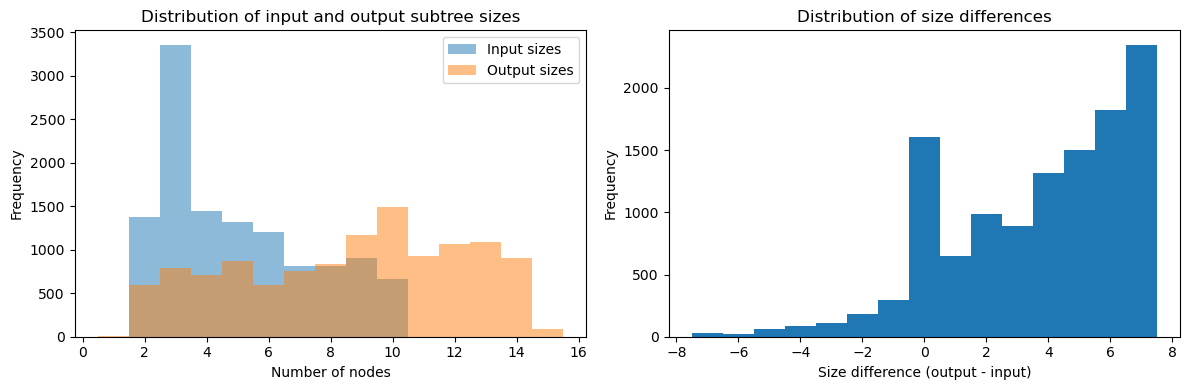

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histograms of in and out sizes on first subplot
ax1.hist(in_sizes, alpha=0.5, label='Input sizes', bins=range(min(in_sizes), max(in_sizes)+2), align='left')
ax1.hist(out_sizes, alpha=0.5, label='Output sizes', bins=range(min(out_sizes), max(out_sizes)+2), align='left')
ax1.set_xlabel('Number of nodes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of input and output subtree sizes')
ax1.legend()

# Plot histogram of differences on second subplot
differences = [out - in_ for out, in_ in zip(out_sizes, in_sizes)]
ax2.hist(differences, bins=range(min(differences), max(differences)+2), align='left')
ax2.set_xlabel('Size difference (output - input)')
ax2.set_ylabel('Frequency') 
ax2.set_title('Distribution of size differences')

plt.tight_layout()
plt.show()


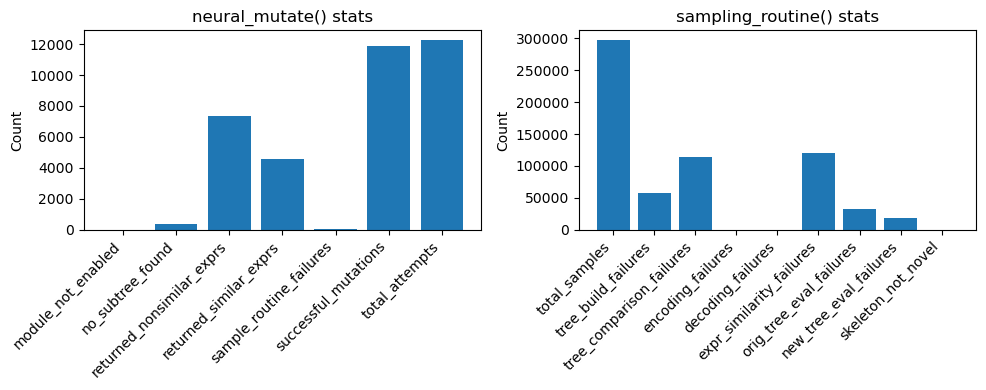

In [15]:
# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Stats to show on right subplot
right_stats = ['total_samples', 'tree_build_failures', 'tree_comparison_failures', 'encoding_failures', 'decoding_failures', 'expr_similarity_failures', 'orig_tree_eval_failures', 'new_tree_eval_failures', 'skeleton_not_novel']

# Left subplot with all other stats
left_stats = {k: v for k, v in count_stats.items() if k not in right_stats}
ax1.bar(left_stats.keys(), left_stats.values())
ax1.set_xticks(range(len(left_stats)))
ax1.set_xticklabels(left_stats.keys(), rotation=45, ha='right')
ax1.set_title('neural_mutate() stats')
ax1.set_ylabel('Count')

# Right subplot with selected stats
right_stats = {k: count_stats[k] for k in right_stats}
ax2.bar(right_stats.keys(), right_stats.values())
ax2.set_xticks(range(len(right_stats)))
ax2.set_xticklabels(right_stats.keys(), rotation=45, ha='right')
ax2.set_title('sampling_routine() stats')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

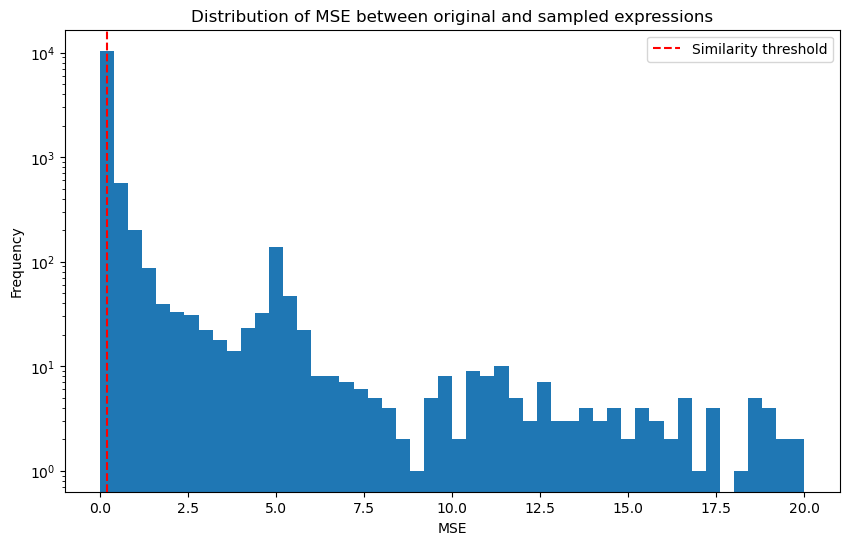

In [17]:
# Plot histogram of MSE values
similarity_threshold = 0.2

plt.figure(figsize=(10, 6))
plt.hist(stats['sampled_mse'], bins=50, range=(0, min(max(stats['sampled_mse']), 20.0)))
plt.axvline(x=similarity_threshold, color='r', linestyle='--', label='Similarity threshold')  # Add vertical line at threshold
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Distribution of MSE between original and sampled expressions')
plt.yscale('log')  # Use log scale since MSE values can span many orders of magnitude
plt.legend()
plt.show()


## Reading TensorBoard data

In [11]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

In [29]:
log_basedir = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/logs'
event_acc = EventAccumulator(os.path.join(log_basedir, 'no-noise_vanilla_0'))
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# # E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
# w_times, step_nums, vals = zip(*event_acc.Scalars('Accuracy'))

{'images': [], 'audio': [], 'histograms': ['search/data/population/complexities'], 'scalars': ['search/data/summaries/min_loss', 'search/data/summaries/pareto_volume', 'search/data/num_evals', 'search/data/equations/complexity=6/loss', 'search/data/equations/complexity=10/loss', 'search/data/equations/complexity=8/loss', 'search/data/equations/complexity=7/loss', 'search/data/equations/complexity=5/loss', 'search/data/equations/complexity=3/loss', 'search/data/equations/complexity=1/loss', 'search/data/equations/complexity=14/loss', 'search/data/equations/complexity=20/loss', 'search/data/equations/complexity=18/loss', 'search/data/equations/complexity=16/loss', 'search/data/equations/complexity=12/loss', 'search/data/equations/complexity=25/loss', 'search/data/equations/complexity=22/loss', 'search/data/equations/complexity=23/loss', 'search/data/equations/complexity=19/loss', 'search/data/equations/complexity=26/loss', 'search/data/equations/complexity=24/loss', 'search/data/equation

In [64]:
event_acc.Scalars('search/data/summaries/min_loss')[0]


ScalarEvent(wall_time=1736525198.557605, step=1, value=14801625088.0)

In [67]:
import pandas as pd
losses = np.array([(e.wall_time, e.step, e.value) for e in event_acc.Scalars('search/data/summaries/min_loss')])

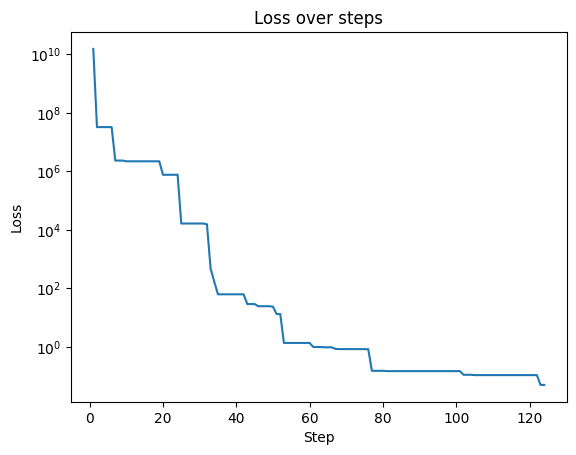

In [71]:
plt.plot(losses[:, 1], losses[:, 2])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over steps')
plt.yscale('log')
plt.show()


## Choosing operators

In [78]:
fpath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/data/FeynmanEquations.csv'
df = pd.read_csv(fpath)
df.head()


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,...,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2a,1.0,f,exp(-theta**2/2)/sqrt(2*pi),1.0,theta,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2,2.0,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.6.2b,3.0,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...,3.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.8.14,4.0,d,sqrt((x2-x1)**2+(y2-y1)**2),4.0,x1,1.0,5.0,x2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I.9.18,5.0,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9.0,m1,1.0,2.0,m2,1.0,...,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN


In [84]:
'log' in df.Formula.str.cat()

False

In [87]:
def find_remaining_ops(formulas):
    operators = ['exp', '*', '**', '/', '+', '-', 'sqrt', 'sin', 'cos', 'tan', 'sinh', 'cosh', 'tanh']
    
    # First count the known operators
    operator_counts = {}
    for formula in formulas.dropna():
        for op in operators:
            # For *, don't count occurrences that are part of **
            if op == '*':
                count = formula.count('*') - 2 * formula.count('**')
            else:
                count = formula.count(op)
            if count > 0:
                operator_counts[op] = operator_counts.get(op, 0) + count
    
    print("Known operator counts:")
    print(pd.Series(operator_counts).sort_values(ascending=False))
    
    # Then remove all known operators and see what's left
    print("\nRemainder after removing known operators:")
    remaining = formulas.copy()
    for op in operators:
        remaining = remaining.str.replace(op, ' ', regex=False)
    
    # Remove numbers, variables, spaces and parentheses
    remaining = remaining.str.replace(r'[0-9]', '', regex=True)
    remaining = remaining.str.replace(r'[a-zA-Z]', '', regex=True)
    remaining = remaining.str.replace(r'[\s\(\)]', '', regex=True)
    remaining = remaining.str.replace('.', '', regex=False)
    
    # Print unique remaining characters
    print("Unique remaining characters:", sorted(set(''.join(remaining.dropna()))))

find_remaining_ops(df.Formula)

Known operator counts:
*       255
/       138
**       87
-        45
+        30
sqrt     18
sin      11
cos      11
exp      10
tan       1
tanh      1
dtype: int64

Remainder after removing known operators:
Unique remaining characters: ['_']


In [86]:
df.Formula.dropna()

0                           exp(-theta**2/2)/sqrt(2*pi)
1           exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)
2     exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...
3                           sqrt((x2-x1)**2+(y2-y1)**2)
4            G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
                            ...                        
95                           (h/(2*pi))**2/(2*E_n*d**2)
96                                     2*pi*alpha/(n*d)
97                            beta*(1+alpha*cos(theta))
98    -m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1...
99                                   -rho_c_0*q*A_vec/m
Name: Formula, Length: 100, dtype: object

## Reading whole benchmark's Tensorboard data

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
prefix = 'full6_'
log_dir = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs/full6_'
matching_dirs = [d for d in os.listdir(log_dir) if d.startswith(prefix)]
len(matching_dirs)


200

In [5]:
def load_tensorboard_data(log_dir, prefixes=None, nsteps=None, early_stop_condition=1e-8, overall_prefix=None, by_type=False):
    # Handle different ways of specifying which runs to load
    if by_type:
        # Get all directories and filter by type
        all_dirs = os.listdir(log_dir)
        if overall_prefix:
            all_dirs = [d for d in all_dirs if d.startswith(overall_prefix)]
            
        # Create a dictionary to store runs by equation number for each type
        matching_dirs = {}
        if 'neural' in by_type:
            neural_dirs = [d for d in all_dirs if 'neural' in d]
            # Group by equation number
            for eq_num in range(1, 101):  # For equations 1-100
                eq_dirs = [d for d in neural_dirs if f'eq{eq_num}_' in d]
                if eq_dirs:
                    matching_dirs[f'neural_eq{eq_num}'] = eq_dirs
                    
        if 'vanilla' in by_type:
            vanilla_dirs = [d for d in all_dirs if 'vanilla' in d]
            # Group by equation number
            for eq_num in range(1, 101):  # For equations 1-100
                eq_dirs = [d for d in vanilla_dirs if f'eq{eq_num}_' in d]
                if eq_dirs:
                    matching_dirs[f'vanilla_eq{eq_num}'] = eq_dirs
    else:
        # Use specified prefixes
        if isinstance(prefixes, str):
            prefixes = [prefixes]
            
        matching_dirs = {}
        for prefix in prefixes:
            full_prefix = f"{overall_prefix}{prefix}" if overall_prefix else prefix
            matching_dirs[prefix] = [d for d in os.listdir(log_dir) if d.startswith(full_prefix)]
    
    assert len(matching_dirs.keys()) > 0, "No matching directories found"

    all_losses = {}
    for prefix, dirs in matching_dirs.items():
        losses = []
        for dir_name in dirs:
            dir_path = os.path.join(log_dir, dir_name)
            event_acc = EventAccumulator(dir_path)
            event_acc.Reload()
            
            try:
                loss_events = event_acc.Scalars('search/data/summaries/min_loss')
                dir_losses = np.array([(e.wall_time, e.step, e.value) for e in loss_events])
                losses.append(dir_losses)
            except KeyError:
                print(f"No loss data found in {dir_name}")
                continue
                
        all_losses[prefix] = losses

    assert len(all_losses.keys()) > 0, "No loss data found"

    # If nsteps not provided, use max steps across all runs
    if nsteps is None:
        nsteps = max(max(x.shape[0] for x in losses) for losses in all_losses.values() if losses)

    # Pad all arrays to nsteps with early_stop_condition value
    for prefix, losses in all_losses.items():
        for i in range(len(losses)):
            current_steps = losses[i].shape[0]
            if current_steps < nsteps:
                # Create padding array with early_stop_condition value
                pad_length = nsteps - current_steps
                last_time = losses[i][-1, 0]  # Last timestamp
                time_increment = (last_time - losses[i][0, 0]) / current_steps  # Average time increment
                
                # Create padding timestamps continuing from last timestamp
                pad_times = np.array([last_time + (j+1)*time_increment for j in range(pad_length)])
                pad_steps = np.arange(current_steps, nsteps)
                pad_values = np.full(pad_length, early_stop_condition)
                
                pad_array = np.column_stack((pad_times, pad_steps, pad_values))
                losses[i] = np.vstack([losses[i], pad_array])

    # Get just the loss values and combine into single array for each prefix
    loss_arrays = {}
    for prefix, losses in all_losses.items():
        if not losses:  # Skip if no data for this prefix
            continue
        loss_array = np.zeros((losses[0].shape[0], len(losses)))
        for i in range(len(losses)):
            loss_array[:, i] = losses[i][:, 2]  # 3rd column is loss value
        loss_arrays[prefix] = loss_array
    
    return loss_arrays

def plot_losses(loss_arrays):
    # Plot losses over time with error margins
    plt.figure(figsize=(10, 6))

    # Generate enough colors using color map
    n_arrays = len(loss_arrays)
    color_map = plt.cm.get_cmap('tab20')  # Use tab20 colormap which has 20 distinct colors
    colors = [color_map(i/min(20, n_arrays)) for i in range(n_arrays)]

    for (prefix, losses), color in zip(loss_arrays.items(), colors):
        mean = np.mean(losses, axis=1)
        std = np.std(losses, axis=1)
        steps = np.arange(len(mean))
        
        plt.plot(steps, mean, label=prefix, color=color)
        plt.fill_between(steps,
                        mean - std,
                        mean + std,
                        alpha=0.3,
                        color=color)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Over Time by Run Type')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
prefixes = [
    'eq20_neural_', 'eq30_neural_', 'eq40_neural_', 'eq50_neural_', 'eq60_neural_', 'eq70_neural_', 'eq80_neural_', 'eq90_neural_',
    'eq20_vanilla_', 'eq30_vanilla_', 'eq40_vanilla_', 'eq50_vanilla_', 'eq60_vanilla_', 'eq70_vanilla_', 'eq80_vanilla_', 'eq90_vanilla_'
]
log_basedir = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs/full6_'
losses = load_tensorboard_data(log_basedir, by_type=['neural', 'vanilla'], overall_prefix='full6_')
# plot_losses(losses)


/tmp/ipykernel_2112950/2542515875.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')  # Use tab20 colormap which has 20 distinct colors


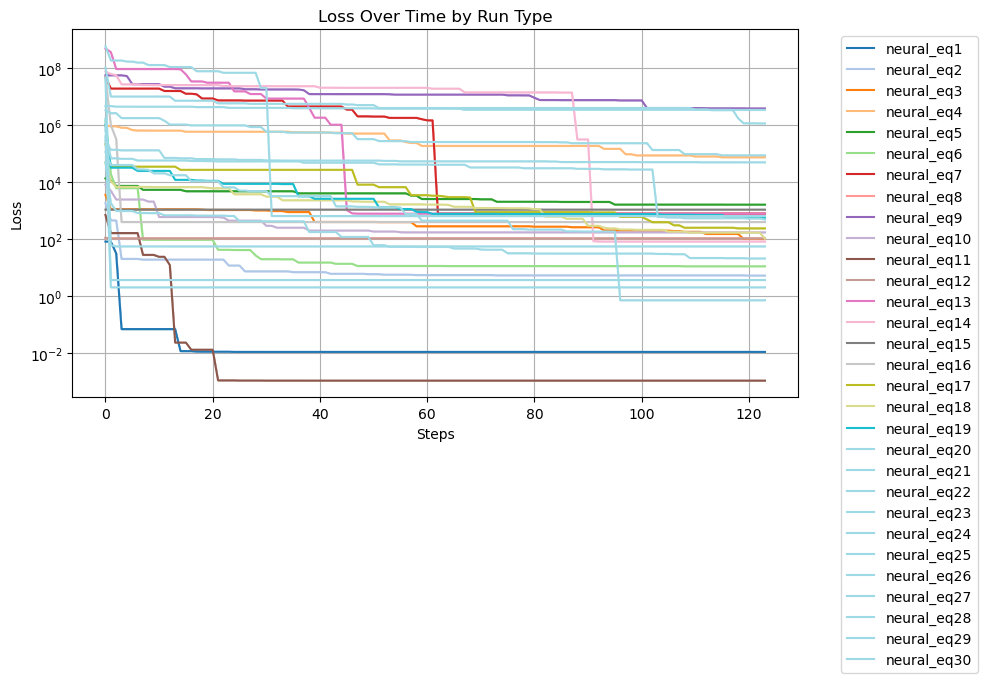

In [6]:
plot_losses({k: v for i, (k, v) in enumerate(losses.items()) if i < 30})

In [7]:
len(losses.keys())

200

In [8]:
def plot_threshold_counts(loss_arrays, threshold=1e-8):
    # Get max length across all arrays to standardize x-axis
    max_len = max(arr.shape[0] for arr in loss_arrays.values())
    steps = np.arange(max_len)
    
    # Group prefixes by type (neural vs vanilla)
    neural_losses = []
    vanilla_losses = []
    
    for prefix, losses in loss_arrays.items():
        if 'neural' in prefix:
            neural_losses.append(losses)
        elif 'vanilla' in prefix:
            vanilla_losses.append(losses)
    
    # Calculate counts below threshold at each timestep
    def get_counts_over_time(loss_list):
        if not loss_list:  # Handle empty lists
            return np.zeros(max_len)
            
        counts = np.zeros(max_len)
        for t in range(max_len):
            # Count how many equations have mean loss below threshold
            total = 0
            for losses in loss_list:
                if t < losses.shape[0]:  # Only count if we have data for this timestep
                    mean_loss = np.mean(losses[t,:])  # Take mean across runs
                    if mean_loss < threshold:
                        total += 1
            counts[t] = total
        return counts
    
    neural_counts = get_counts_over_time(neural_losses)
    vanilla_counts = get_counts_over_time(vanilla_losses)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    if len(neural_losses) > 0:
        plt.plot(steps, neural_counts, label='Neural', color='blue')
    if len(vanilla_losses) > 0:
        plt.plot(steps, vanilla_counts, label='Vanilla', color='red')
    
    plt.xlabel('Steps')
    plt.ylabel(f'Number of Equations with Mean Loss Below {threshold:0.0e}')
    plt.title('Count of Successful Equations Over Time')
    plt.ylim(0, len(loss_arrays.keys())//2)
    plt.xlim(0, 125)
    plt.legend()
    plt.grid(True)
    plt.show()


## Synthetic run 2
Added resmpling and other checks

run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: syntheticNoLog2_
  do_vanilla: true
  do_neural: true

dataset:
  name: synthetic
  num_samples: 10000  # Same settings as full1_
  noise: 0
  equation_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]  # , 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.02
    subtree_min_nodes: 2
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 9
    max_resamples: 29
    require_tree_size_similarity: true
    require_novel_skeleton: true
    require_expr_similarity: true
    similarity_threshold: 0.4  # Using double actual similarity_threshold to speed up computation
  weight_neural_mutate_tree: 1.0  # Only used for neural runs. 

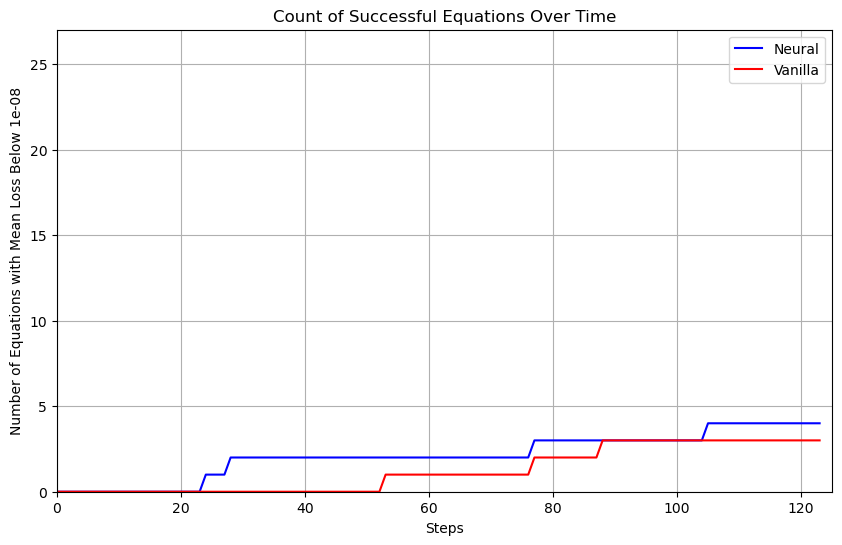

In [24]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Synthetic run 1
run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: syntheticNoLog1_
  do_vanilla: true
  do_neural: true

dataset:
  name: synthetic
  num_samples: 10000  # Same settings as full1_
  noise: 0
  equation_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]  # , 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.03
    subtree_min_nodes: 3
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 7
    max_resamples: 9
  weight_neural_mutate_tree: 1.0  # Only used for neural runs. 

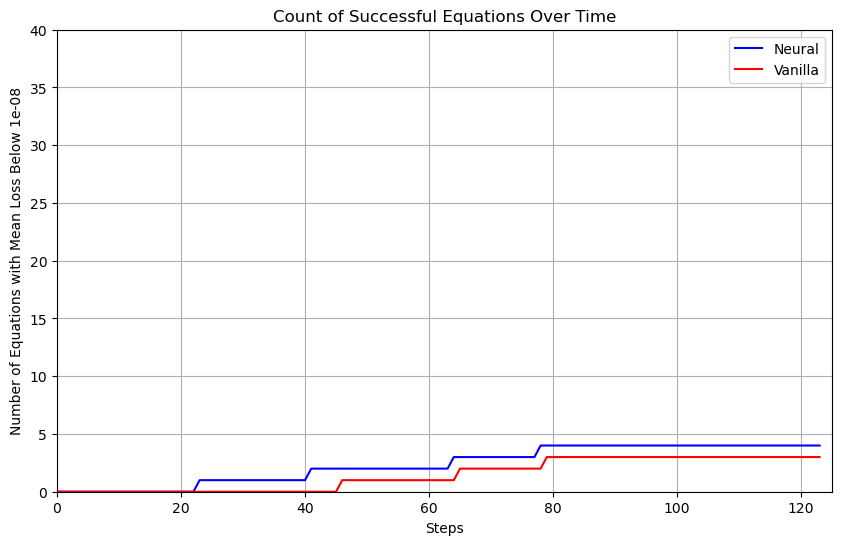

In [40]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Run 4
10k points, noise=0, with resampling

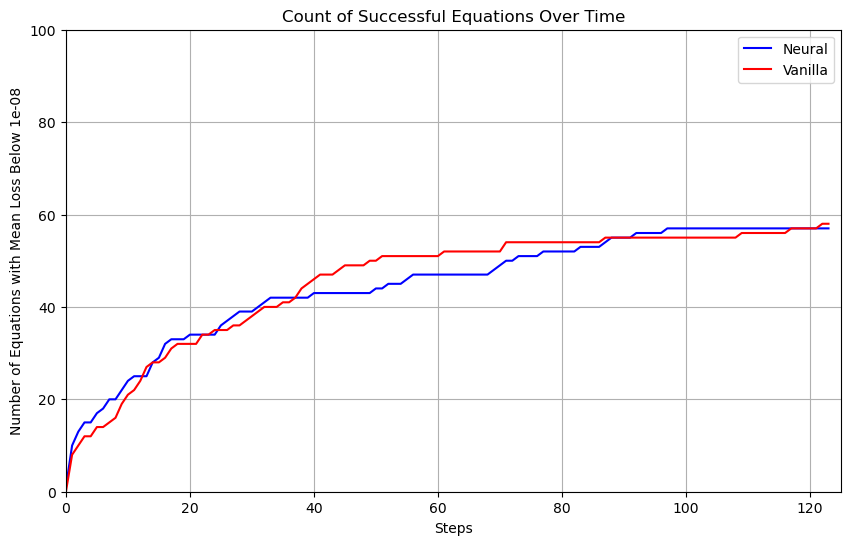

In [11]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Run 2
100k points, noise=1e-3

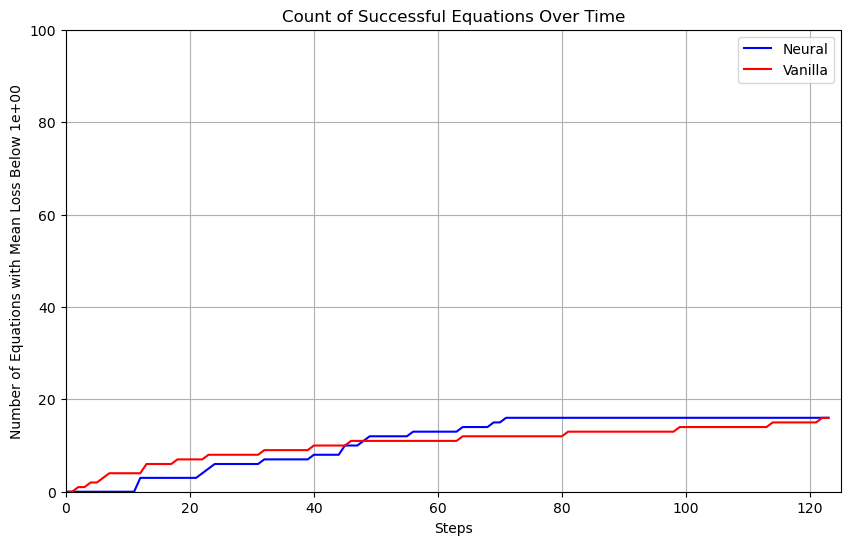

In [40]:
# Plot using the losses from previous cell
plot_threshold_counts(losses, threshold=1.1e0)


## Run 1
10k points, no noise

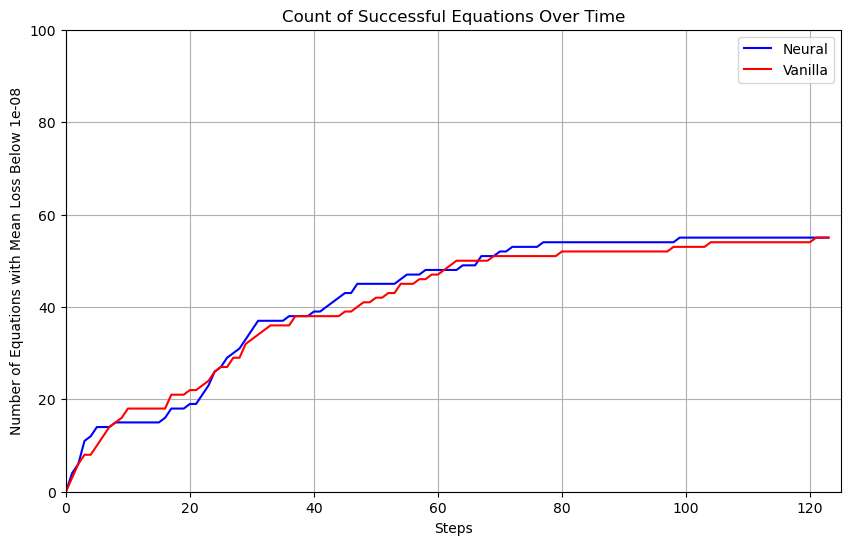

In [27]:
# Plot using the losses from previous cell
plot_threshold_counts(losses, threshold=1.1e-8)


### Run 6

run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: full6_
  do_vanilla: true
  do_neural: true

dataset:
  name: feynman
  num_samples: 100000  # Same settings as full1_
  noise: 1e-3
  equation_indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.02
    subtree_min_nodes: 2
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 9
    max_resamples: 29
    require_tree_size_similarity: true
    require_novel_skeleton: true
    require_expr_similarity: true
    similarity_threshold: 0.4  # Using double actual similarity_threshold to speed up computation
  weight_neural_mutate_tree: 1.0  # Only used for neural runs. 






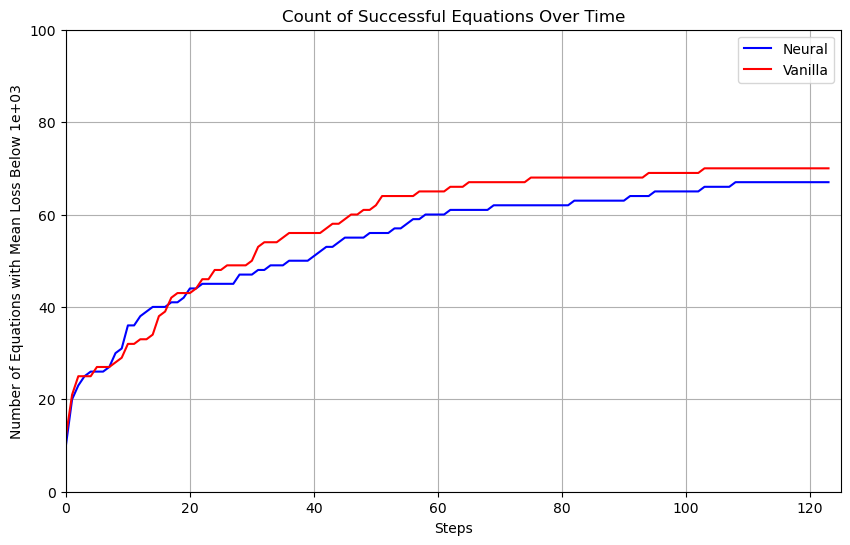

In [15]:
plot_threshold_counts(losses, threshold=1.1e3)